# Final Project
## Can we predict whether a mushroom is edible or poisonous? 

### March 9, 2022

**My Checklist!**
- Explore the data
    - subplots displaying the overall trends of certain variables
    - variable types
    - number of unique values per variables
    - check class distribution
- Pre-process the data
    - convert nominal to numerical
    - handle the null values
    - feature engineering
        - correlation matrix
        - plot that displays the most important features
    - one-hot encode 
    - standardize
    - resampling (smoteen?)
- Compute classification models
    - Decision tree
    - Logistic regression 
    - KNN
    - Random Forest
    - XGBoost
- Tune the models
    - GridSearchCV
    - Select best way to evaluate the model (recall??)
- Finalize model
    - Choose whichever model is the best
- Write interpretations and conclusions
- Create presentation

**Set-up and Initial Exploration**

In [12]:
# load initial libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read in the secondary data set
mushroom = pd.read_csv('secondary_data.csv', sep=';')

# View the first few rows
mushroom.head(5)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
mushroom.shape

(61069, 21)

### Exploratory Analysis

Before any modeling or pre-processing, I will first explore the data to better understand overall trends, data types, etc.

**Examine the dependent variable**

In [34]:
# There are precisely two class variables: poisonous and edible
mushroom['class'].unique()

array(['p', 'e'], dtype=object)

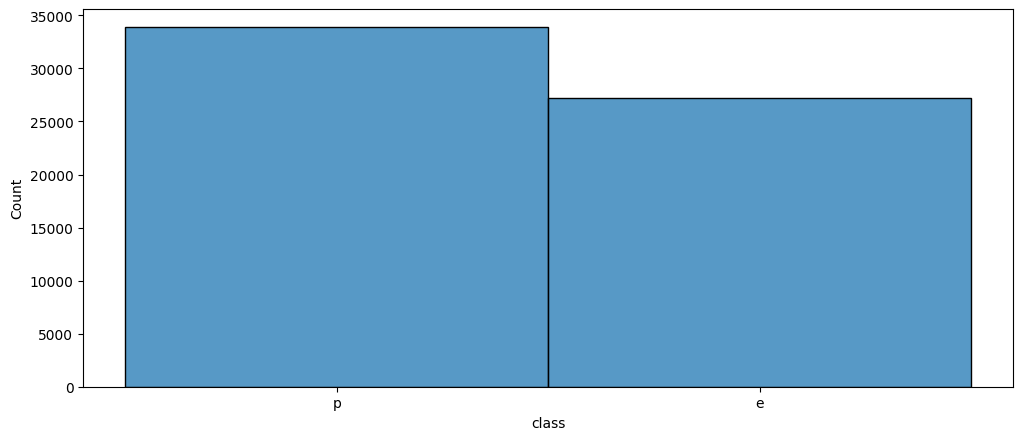

In [39]:
# View the distribution to see how equal they are
# Edible is the minority class
g = sns.histplot(x='class', data=mushroom)

In [41]:
# Total poisonous
poison = sum(mushroom['class']=='p')
# Total edible
edible = sum(mushroom['class']=='e')

# Distribution of classes
print(poison/(len(mushroom.index)))
print(edible/len(mushroom.index))

0.5549132947976878
0.44508670520231214


Approximately 55% of the data are poisonous, while 44.5% of the data are edible. This is a reasonably equal distribution for our model. We will run this again after pre-processing and handling nulls to ensure we did not exacerbate any class inequities. 

**Examine continuous variables**

In [4]:
# View numerical data
mushroom.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


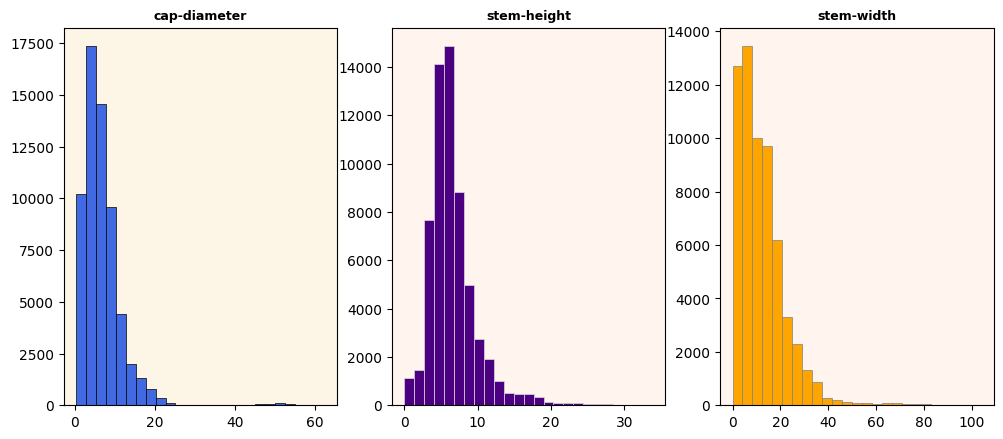

In [38]:
# Set up the axes
fig, axes = plt.subplots(1, 3)

# Set up histograms
axes[0].hist(mushroom['cap-diameter'], bins=25, color='royalblue', edgecolor='black', linewidth=0.5)
axes[0].set_title('cap-diameter', size=9, weight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_facecolor('oldlace')


axes[1].hist(mushroom['stem-height'], bins=25, color='indigo', edgecolor='gainsboro', linewidth=0.5)
axes[1].set_title('stem-height', size=9, weight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_facecolor('seashell')

axes[2].hist(mushroom['stem-width'], bins=25, color='orange', edgecolor='gray', linewidth=0.5)
axes[2].set_title('stem-width', size=9, weight='bold')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_facecolor('seashell')

# Make plots larger
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})

# Show plot
plt.show()

Our three continuous variables are right-skewed, but the stem-height is closest to a normal bell curve shape when compared to the other two. It seems that the cap-diameter variable also has a few outliers that we might need to consider removing. 

**Examine nominal variables**

In [48]:
# Isolate columns that are nominal
nom_df = mushroom.drop(['class', 'cap-diameter', 'stem-height', 'stem-width'], axis=1)

# Loop through variables in data frame
for col in nom_df.columns:
    # print unique variables
    print(f'{col}: {nom_df[col].unique()}')

cap-shape: ['x' 'f' 'p' 'b' 'c' 's' 'o']
cap-surface: ['g' 'h' nan 't' 'y' 'e' 's' 'l' 'd' 'w' 'i' 'k']
cap-color: ['o' 'e' 'n' 'g' 'r' 'w' 'y' 'p' 'u' 'b' 'l' 'k']
does-bruise-or-bleed: ['f' 't']
gill-attachment: ['e' nan 'a' 'd' 's' 'x' 'p' 'f']
gill-spacing: [nan 'c' 'd' 'f']
gill-color: ['w' 'n' 'p' 'u' 'b' 'g' 'y' 'r' 'e' 'o' 'k' 'f']
stem-root: ['s' nan 'b' 'r' 'c' 'f']
stem-surface: ['y' nan 's' 'k' 'i' 'h' 't' 'g' 'f']
stem-color: ['w' 'y' 'n' 'u' 'b' 'l' 'r' 'p' 'e' 'k' 'g' 'o' 'f']
veil-type: ['u' nan]
veil-color: ['w' 'y' nan 'n' 'e' 'u' 'k']
has-ring: ['t' 'f']
ring-type: ['g' 'p' 'e' 'l' 'f' 'm' nan 'r' 'z']
spore-print-color: [nan 'w' 'p' 'k' 'r' 'u' 'n' 'g']
habitat: ['d' 'm' 'g' 'h' 'l' 'p' 'w' 'u']
season: ['w' 'u' 'a' 's']


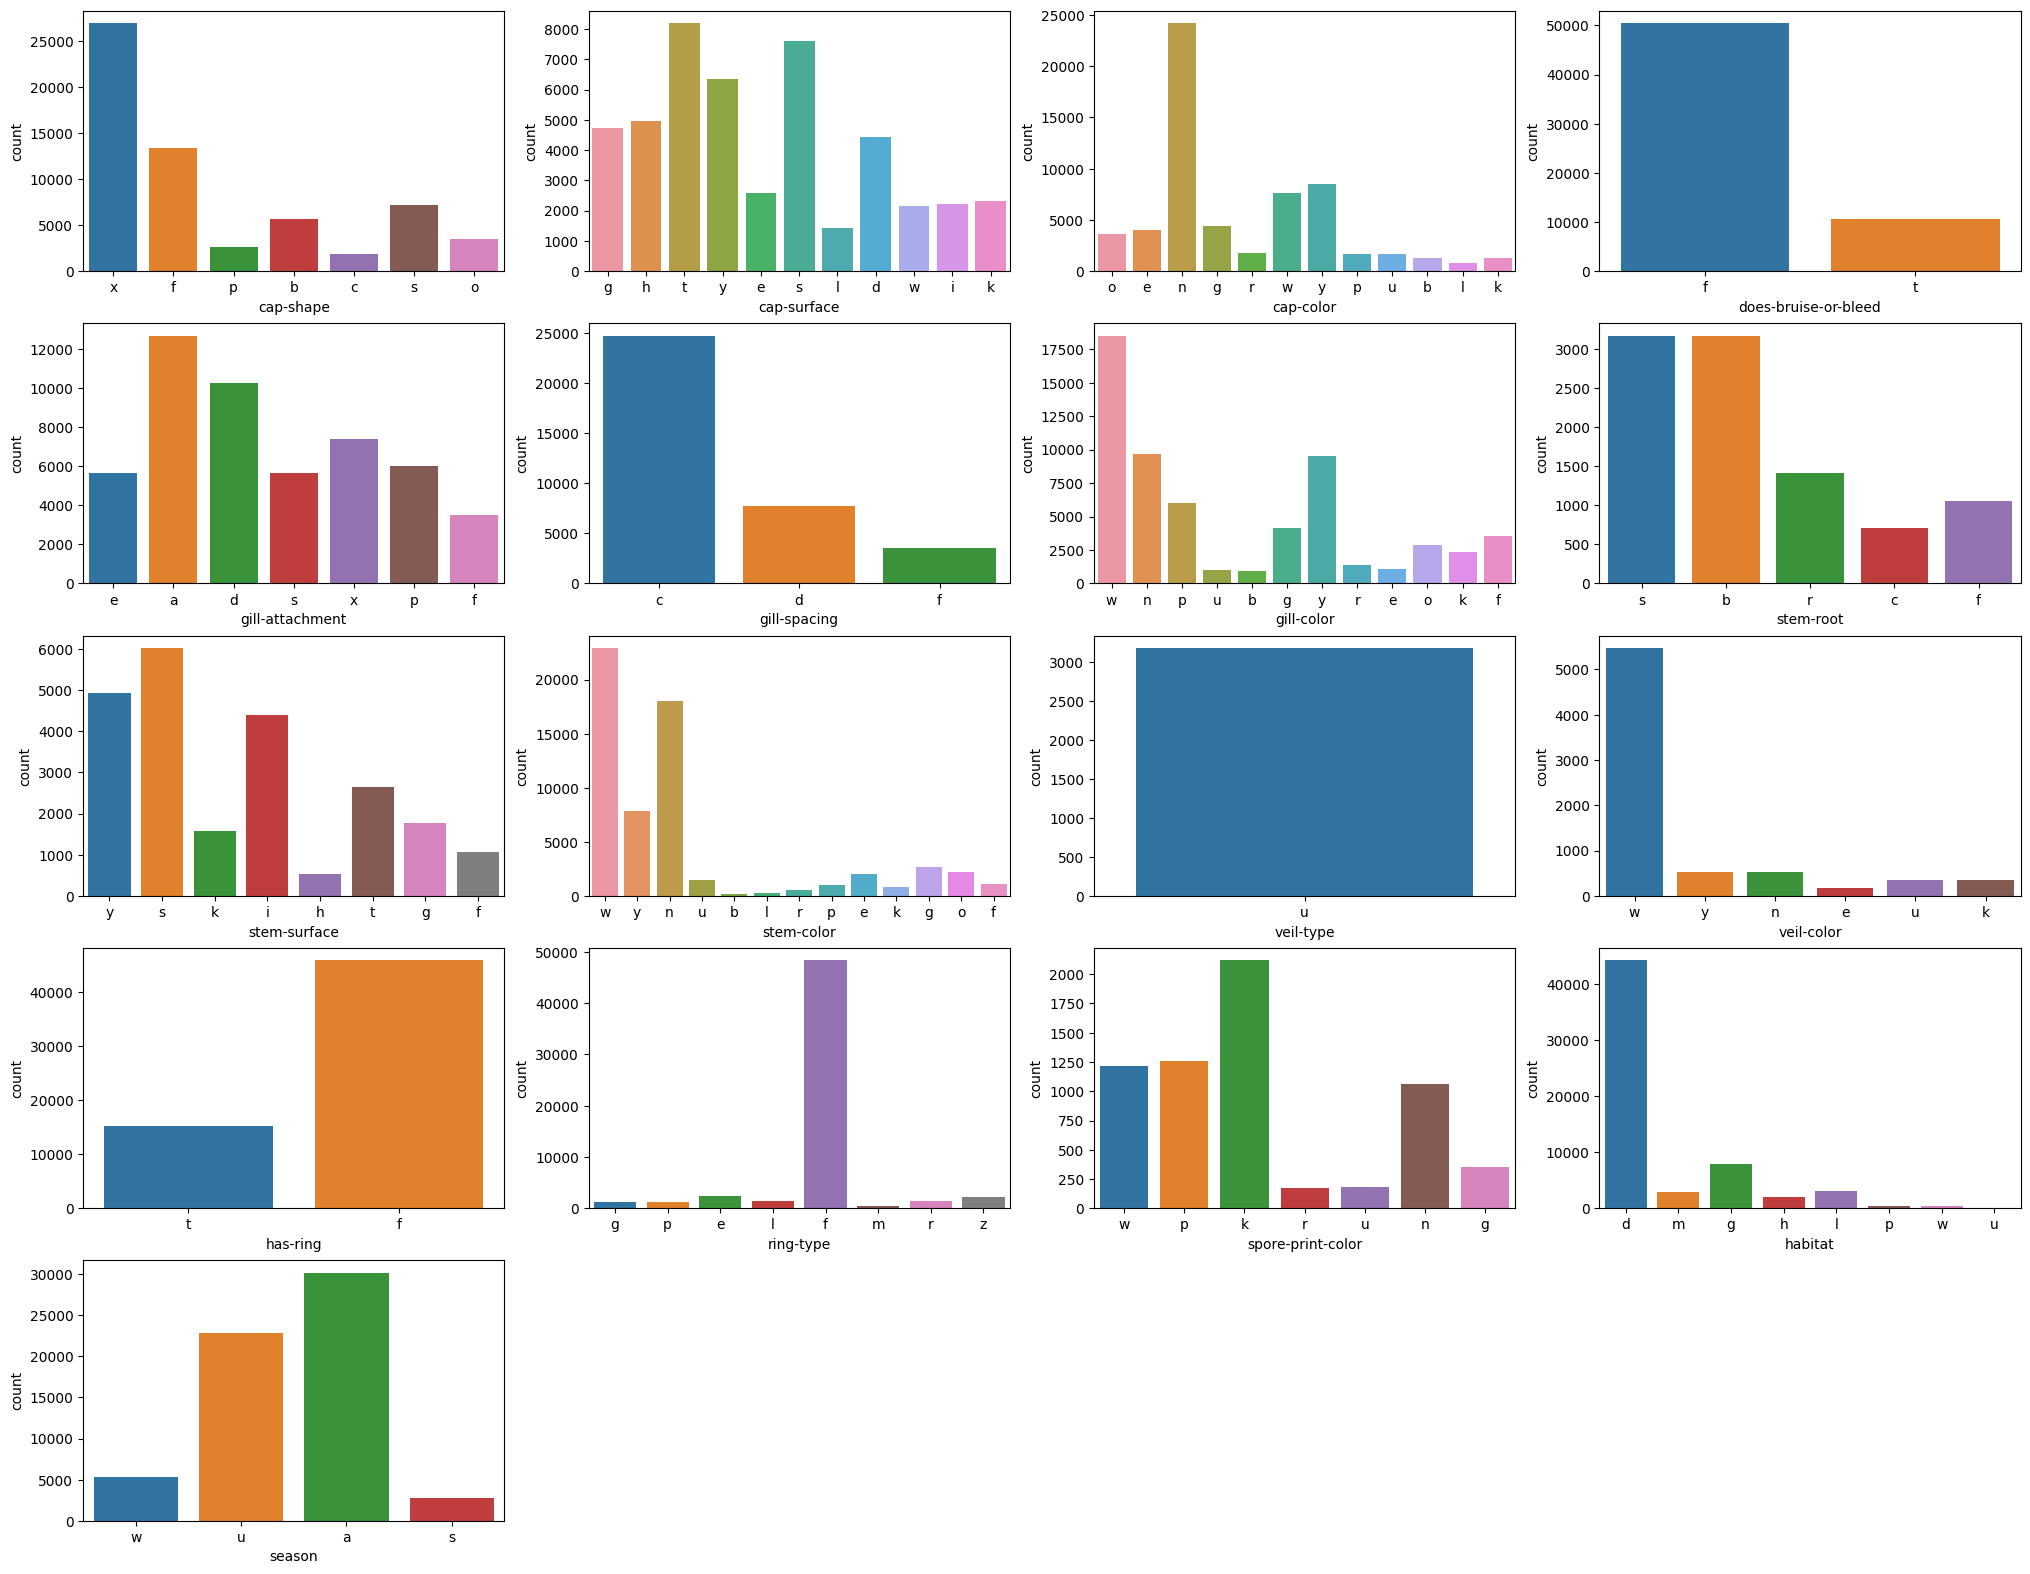

In [62]:
# Place the nominal variables into a list
nom_vars = nom_df.columns.tolist()

# Set columns and rows
cols = 4
rows = 5

# Set fig size
fig = plt.figure(figsize=(25, 20))

# Set up subplots
for i, val in enumerate(nom_vars):
    # 5 rows and 4 cols with 17 plots
    ax = fig.add_subplot(rows, cols, i+1)
    # Extract the data
    sns.countplot(x=val, data=mushroom)

Many of these variables have very unequal distributions. There are some variables, such as "ring-type," where the extreme vast majority of data points are all one type. Similarly, veil type only as one class, since the rest our NAN. That is one feature that we will be able to easily eliminate right away.

### Pre-processing

**Handle null values**

Check the number of null values per variable

In [63]:
# See how many are null
mushroom.isna().sum()

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

There are 9 variables out of the 20 variables in our data set that have missing values. With the exception of "ring-type," all of these features have over 10% missing. We cannot remove the rows with missing data, as this would severely compromise the analysis. It also would not be wise to simply fill the NAs with a random value, such as '99' because this could also hinder results. Therefore, I will completely remove the features with NAs. I will also remove the "ring-type" variable because although only 2,471 are missing, the vast majority of data points are all one type.

In [65]:
# Drop the null feature
complete_mushroom = mushroom.drop(['cap-surface', 'gill-attachment', 'gill-spacing', 
                                   'stem-root', 'stem-surface', 'veil-type', 
                                   'veil-color', 'ring-type', 'spore-print-color'], axis=1)
complete_mushroom.isna().sum()

class                   0
cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
habitat                 0
season                  0
dtype: int64

Encoding our variables

In [8]:
# Encode nominal variables
from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
le = LabelEncoder()

# Iterate through the columns in the mushroom data set
for col in mushroom.columns:
    # fit the encoder to our data
    mushroom[col] = le.fit_transform(mushroom[col])

mushroom.sample(10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
23197,1,1101,6,8,5,0,0,1,10,1206,...,5,8,11,1,6,0,1,7,0,2
16849,0,706,2,2,6,0,5,3,11,732,...,5,3,7,1,6,0,1,7,0,0
1803,0,612,6,11,10,0,2,3,10,464,...,0,8,12,0,4,1,2,7,0,0
32725,1,285,5,0,10,0,0,1,10,276,...,5,2,11,1,6,0,1,7,1,2
3059,0,1698,4,10,10,0,7,3,10,2103,...,4,8,6,1,6,1,4,7,4,2
25613,1,517,6,3,1,0,6,1,10,482,...,0,8,11,1,6,0,1,7,0,0
5370,0,730,2,11,5,0,5,0,7,562,...,0,8,10,1,6,0,1,7,0,3
13657,1,104,6,2,11,0,1,1,5,90,...,5,5,6,1,6,0,1,7,2,2
15738,1,746,6,7,5,1,5,1,10,481,...,3,7,11,1,6,0,1,7,0,0
22000,0,389,6,11,11,0,0,0,6,413,...,5,8,11,1,6,0,1,7,0,0


Standardize variables and split into training vs. testing

In [9]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Get our predicted variables
X = mushroom.drop('class', axis=1)
# Get our outcome variable
y = mushroom['class']

# Split our data into training vs. testing
# We want to compute the model on our training data to train the model
# We then use that model on our testing data set to see the performance
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state=33)

# Standardize our data
sc=StandardScaler()
# Standardize training values
X_train = sc.fit_transform(X_train)
# Standardize testing values
X_test=sc.fit_transform(X_test)

### Logistic Regression

In [10]:
# Needed to run the logistic regression
from sklearn.linear_model import LogisticRegression

# Compute the logistic regression
logreg_model = LogisticRegression(random_state=33).fit(X_train, y_train)

# Find the predicted values (predict edible or poisonous)
y_predicted = logreg_model.predict(X_test)

In [11]:
# Import modules to compute classification report
from sklearn.metrics import classification_report

# See a classification report so that we know how well we did at predicting diabetes
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      8228
           1       0.66      0.76      0.70     10093

    accuracy                           0.65     18321
   macro avg       0.65      0.64      0.64     18321
weighted avg       0.65      0.65      0.64     18321

